In [2]:
# --- Latent Diffusion Interactive Playground ---
# Run this in a Jupyter notebook cell.
import sys, os
sys.path.append(r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav")
import torch
import imageio
from modules.diffusion import LatentDiffusion  # adjust import to your project structure
from torchvision.utils import save_image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
import time 

2.1.2
None
None


# Functions

In [3]:


def plot_diffusion_progress(history, autoencoder=None, every_n=10, decode=False,
                            out_dir="diffusion_frames", show_metric=True):
    """
    Saves every Nth latent (optionally decoded) as PNG and plots mean(|noise|) vs timestep.
    """
    os.makedirs(out_dir, exist_ok=True)
    latents = history["latents"]
    noise = history["noise"]

    means = [n.abs().mean().item() for n in noise]
    steps = list(range(len(noise)))

    # save frames
    for i in range(0, len(latents), every_n):
        x = latents[i].detach().cpu()
        img = x[0]  # first sample in batch
        if decode and autoencoder is not None:
            img = autoencoder.decoder(x.to(next(autoencoder.parameters()).device))[0].detach().cpu()
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        save_path = os.path.join(out_dir, f"step_{i:04d}.png")
        save_image(img, save_path)

    if show_metric:
        plt.figure()
        plt.plot(steps, means)
        plt.xlabel("Timestep")
        plt.ylabel("Mean |noise|")
        plt.title("Diffusion Denoising Progress")
        plt.tight_layout()
        plt.show()


def make_diffusion_gif(history, autoencoder=None, decode=False, out_dir="diffusion_gif",
                       fps=5, resize=False, size=(512, 512), cleanup=False):
    """
    Saves all latent steps as frames and compiles them into a GIF.
    """
    os.makedirs(out_dir, exist_ok=True)
    latents = history["latents"]

    frame_paths = []
    for i, x in enumerate(latents):
        x = x.detach().cpu()
        img = x[0]
        if decode and autoencoder is not None:
            img = autoencoder.decoder(x.to(next(autoencoder.parameters()).device))[0].detach().cpu()
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        save_path = os.path.join(out_dir, f"frame_{i:04d}.png")
        save_image(img, save_path)
        frame_paths.append(save_path)

    # create GIF
    frames = []
    for path in frame_paths:
        img = imageio.imread(path)
        if resize:
            img = TF.resize(TF.to_pil_image(torch.tensor(img).permute(2, 0, 1) / 255.0), size)
            img = (torch.tensor(TF.to_tensor(img)).permute(1, 2, 0).numpy() * 255).astype("uint8")
        frames.append(img)

    gif_path = os.path.join(out_dir, "diffusion.gif")
    imageio.mimsave(gif_path, frames, fps=fps)

    if cleanup:
        for p in frame_paths:
            os.remove(p)

    print(f"GIF saved to {gif_path}")


# Experiments 

[Encoder] Layer 0: in=3, out=32, size=256x256
[Encoder] Layer 1: in=32, out=64, size=128x128
[Encoder] Layer 2: in=64, out=128, size=64x64
[Encoder] Conv output: 128x64x64
[Encoder] Latent output: 4x64x64
[Decoder] Latent input: 4x64x64
[Decoder] Decoder start: 128x64x64
[Decoder] Layer 0: in=128, out=128, size=128x128
[Decoder] Layer 1: in=128, out=64, size=256x256
[Decoder] Layer 2: in=64, out=32, size=512x512
[Decoder] Final output: 3x512x512
scheduler steps = 200
Loaded LatentDiffusion model on cpu
Latent shape: (4, 64, 64)
Generating...


Diffusion sampling: 100%|██████████| 200/200 [00:24<00:00,  8.04it/s]


Decoding...
Layout generation took 25.270 seconds


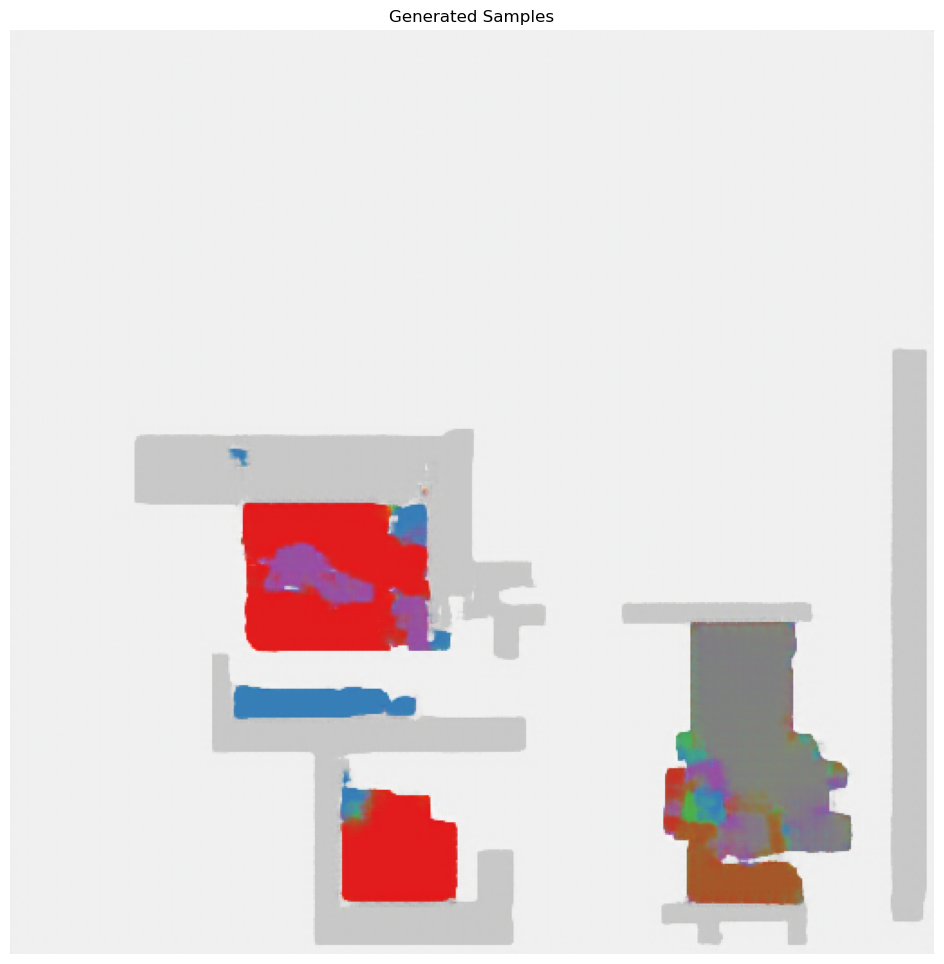

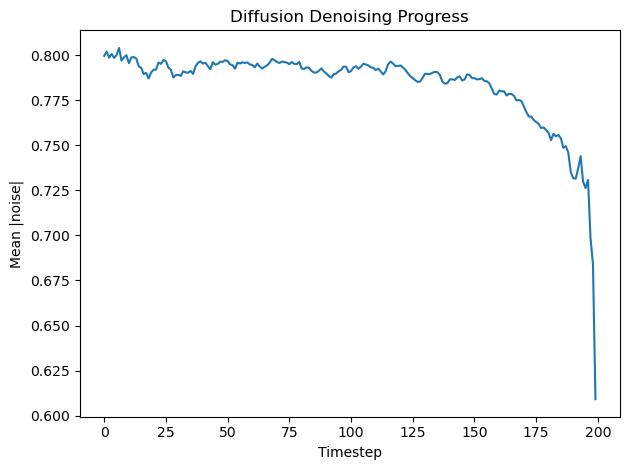

C:\Users\Hagai.LAPTOP-QAG9263N\AppData\Local\Temp\ipykernel_20220\2718899376.py:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(path)
C:\Users\Hagai.LAPTOP-QAG9263N\AppData\Local\Temp\ipykernel_20220\2718899376.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = (torch.tensor(TF.to_tensor(img)).permute(1, 2, 0).numpy() * 255).astype("uint8")


GIF saved to outputs/diffusion_gif\diffusion.gif


In [5]:
# --- Load pre-trained model ---
config_path_1 = r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav\config\diffusion_1.yml"
device = "cuda" if torch.cuda.is_available() else "cpu"

model_1 = LatentDiffusion.from_config(config_path_1, device=device)
print(f"scheduler steps = {model_1.scheduler.num_steps}")
print(f"Loaded LatentDiffusion model on {device}")
print(f"Latent shape: {model_1.latent_shape}")

batch_size = 1
num_steps = 200 
generate_images = True  
use_conditioning = False  


# --- Generate samples ---
start = time.time()

samples,history = model_1.sample(
    batch_size=batch_size,
    image=generate_images,
    num_steps=num_steps,
    device=device,
    return_latents=True
)
end = time.time()
print(f"Layout generation took {end - start:.3f} seconds")


if generate_images:
    imgs = samples.detach().cpu()

    # Ensure [B, C, H, W]
    if imgs.ndim == 4 and imgs.shape[-1] in [1, 3]:
        imgs = imgs.permute(0, 3, 1, 2)

    nrow = 4
    total = len(imgs)
    ncol = (total + nrow - 1) // nrow  # number of rows

    rows = []
    for i in range(ncol):
        row_imgs = imgs[i * nrow : (i + 1) * nrow]
        row = torch.cat([img for img in row_imgs], dim=2)
        rows.append(row)

    grid = torch.cat(rows, dim=1).permute(1, 2, 0)

    plt.figure(figsize=(12, 12))
    plt.imshow(grid)
    plt.axis("off")
    plt.title("Generated Samples")
    plt.show()
else:
    print("Generated latent samples:", samples.shape)


# 1. visualize diffusion progress every 20 steps
plot_diffusion_progress(
    history=history,
    autoencoder=model_1.autoencoder,
    every_n=20,
    decode=True,
    out_dir="outputs/diffusion_progress",
    show_metric=True
)


# 2. generate full diffusion GIF (all steps)
make_diffusion_gif(
    history=history,
    autoencoder=model_1.autoencoder,
    decode=True,
    out_dir="outputs/diffusion_gif",
    fps=8,
    resize=True,
    size=(512, 512),
    cleanup=False
)

[Encoder] Layer 0: in=3, out=32, size=256x256
[Encoder] Layer 1: in=32, out=64, size=128x128
[Encoder] Layer 2: in=64, out=128, size=64x64
[Encoder] Conv output: 128x64x64
[Encoder] Latent output: 4x64x64
[Decoder] Latent input: 4x64x64
[Decoder] Decoder start: 128x64x64
[Decoder] Layer 0: in=128, out=128, size=128x128
[Decoder] Layer 1: in=128, out=64, size=256x256
[Decoder] Layer 2: in=64, out=32, size=512x512
[Decoder] Final output: 3x512x512
scheduler steps = 500
Loaded LatentDiffusion model on cpu
Latent shape: (4, 64, 64)
Generating...


Diffusion sampling: 100%|██████████| 500/500 [02:07<00:00,  3.93it/s]


Decoding...
Layout generation took 127.353 seconds


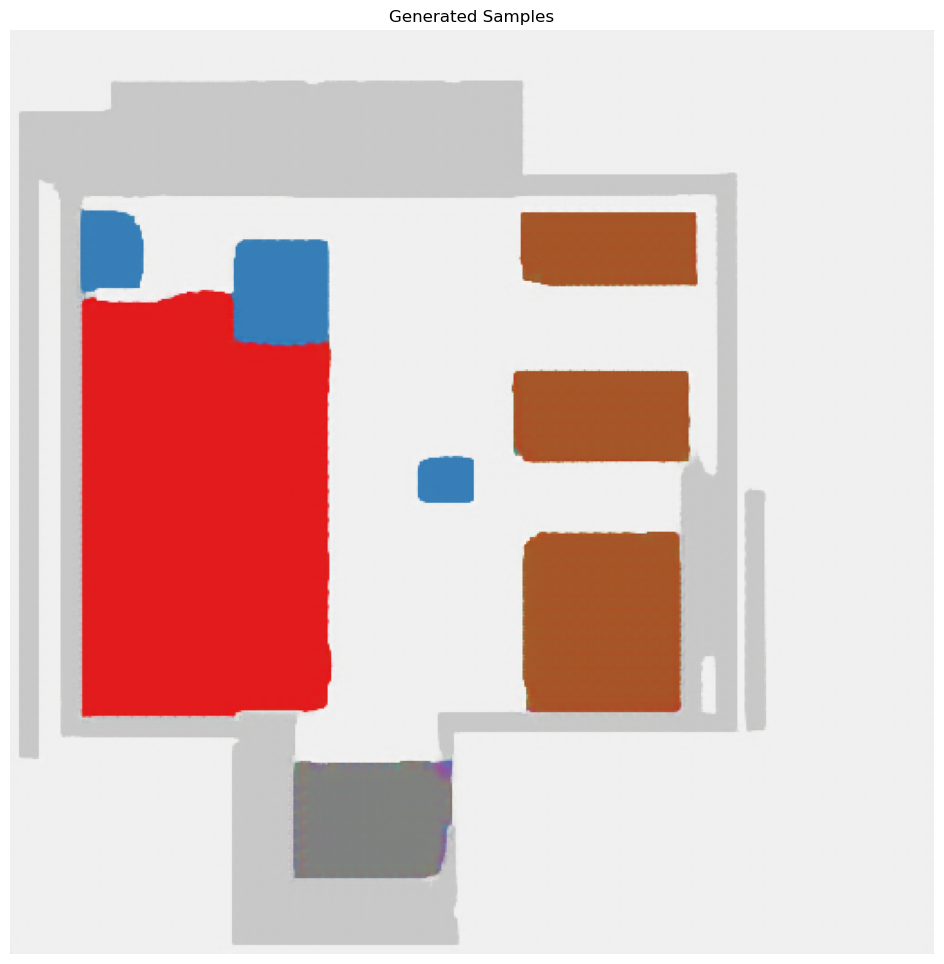

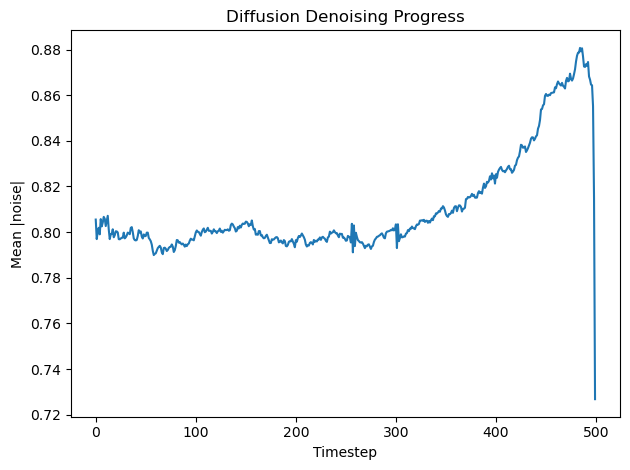

C:\Users\Hagai.LAPTOP-QAG9263N\AppData\Local\Temp\ipykernel_9376\2718899376.py:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(path)
C:\Users\Hagai.LAPTOP-QAG9263N\AppData\Local\Temp\ipykernel_9376\2718899376.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = (torch.tensor(TF.to_tensor(img)).permute(1, 2, 0).numpy() * 255).astype("uint8")


GIF saved to outputs/diffusion_medium_gif\diffusion.gif


In [15]:
# --- Load pre-trained model ---
condig_path_2 = r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav\config\diffusion_2.yml"
device = "cuda" if torch.cuda.is_available() else "cpu"

model_2 = LatentDiffusion.from_config(condig_path_2, device=device)
print(f"scheduler steps = {model_2.scheduler.num_steps}")
print(f"Loaded LatentDiffusion model on {device}")
print(f"Latent shape: {model_2.latent_shape}")

batch_size = 1
num_steps = 500 
generate_images = True 


# --- Generate samples ---

start = time.time()

samples, history = model_2.sample(
    batch_size=batch_size,
    image=generate_images,
    return_latents=True,
    num_steps=num_steps,
    device=device
)

end = time.time()
print(f"Layout generation took {end - start:.3f} seconds")


if generate_images:
    imgs = samples.detach().cpu()

    # Ensure [B, C, H, W]
    if imgs.ndim == 4 and imgs.shape[-1] in [1, 3]:
        imgs = imgs.permute(0, 3, 1, 2)

    nrow = 4
    total = len(imgs)
    ncol = (total + nrow - 1) // nrow  # number of rows

    rows = []
    for i in range(ncol):
        row_imgs = imgs[i * nrow : (i + 1) * nrow]
        row = torch.cat([img for img in row_imgs], dim=2)
        rows.append(row)

    grid = torch.cat(rows, dim=1).permute(1, 2, 0)

    plt.figure(figsize=(12, 12))
    plt.imshow(grid)
    plt.axis("off")
    plt.title("Generated Samples")
    plt.show()
else:
    print("Generated latent samples:", samples.shape)


# 1. visualize diffusion progress every 20 steps
plot_diffusion_progress(
    history=history,
    autoencoder=model_2.autoencoder,
    every_n=20,
    decode=True,
    out_dir="outputs/diffusion_progress_medium",
    show_metric=True
)


# 2. generate full diffusion GIF (all steps)
make_diffusion_gif(
    history=history,
    autoencoder=model_2.autoencoder,
    decode=True,
    out_dir="outputs/diffusion_medium_gif",
    fps=8,
    resize=True,
    size=(512, 512),
    cleanup=False
)